# Brain MRI - Image Segmentation
------

In [41]:
import os
import PIL
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import torchvision.transforms.functional as F
from torchvision import transforms as transforms
import torch.nn as nn
import torch
from torchsummary import summary

from imgseg import show, plot_random_masked_images, plot_one_image_mask
from imgseg import DoubleConvLayer, UNet
from imgseg import get_dataloader, SegmentationDataset

## Create Folder, Organize Data

In [2]:
if not os.path.isdir('./kaggle_3m/images'):
    os.mkdir('./kaggle_3m/images')
if not os.path.isdir('./kaggle_3m/masks'):
    os.mkdir('./kaggle_3m/masks')

In [3]:
all_images = []
def unpack_folder(path: str):
    """Unpacks folder recusrively and appends to global list."""
    files = os.listdir(path)
    for f in files:
        if '.tif' in f:
            all_images.append(os.path.join(path, f))
        elif os.path.isdir(os.path.join(path, f)):
            unpack_folder(os.path.join(path, f)) 

In [4]:
unpack_folder('kaggle_3m/')
all_images[:5]

['kaggle_3m/images/TCGA_CS_4941_19960909_1.tif',
 'kaggle_3m/images/TCGA_CS_4941_19960909_10.tif',
 'kaggle_3m/images/TCGA_CS_4941_19960909_11.tif',
 'kaggle_3m/images/TCGA_CS_4941_19960909_12.tif',
 'kaggle_3m/images/TCGA_CS_4941_19960909_13.tif']

In [5]:
REPLACE_FILES = False
new_path_images = './kaggle_3m/images/'
new_path_masks = './kaggle_3m/masks/'

if REPLACE_FILES:
    for file in tqdm(all_images):
        img = Image.open(file)
        name = os.path.split(file)[-1]
        if 'mask' in name and name not in os.listdir(new_path_masks):
            img.save(os.path.join(new_path_masks, name))
        elif name not in os.listdir(new_path_images):
            img.save(os.path.join(new_path_images, name))

In [6]:
# build pandas dataset linking each mask with the real image
all_images = os.listdir(new_path_images)
all_masks = os.listdir(new_path_masks)
identifier = [img.split('.')[0] for img in all_images]

In [7]:
df_images = pd.DataFrame({'identifier': identifier, 'image': all_images})
df_masks = pd.DataFrame({'mask':all_masks})
df_masks['identifier'] = df_masks['mask'].apply(lambda x: x.split('_mask.tif')[0])
df = pd.merge(left=df_images, right=df_masks, on='identifier', how='inner')
df['patient_key'] = df['identifier'].apply(lambda x: '_'.join(x.split('_')[:-2]))

df.head(2)

,identifier,image,mask,patient_key
0,TCGA_CS_4941_19960909_1,TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909_1_mask.tif,TCGA_CS_4941
1,TCGA_CS_4941_19960909_10,TCGA_CS_4941_19960909_10.tif,TCGA_CS_4941_19960909_10_mask.tif,TCGA_CS_4941


In [8]:
assert df.isnull().sum().sum() == 0

## Visualize Scans with Masks

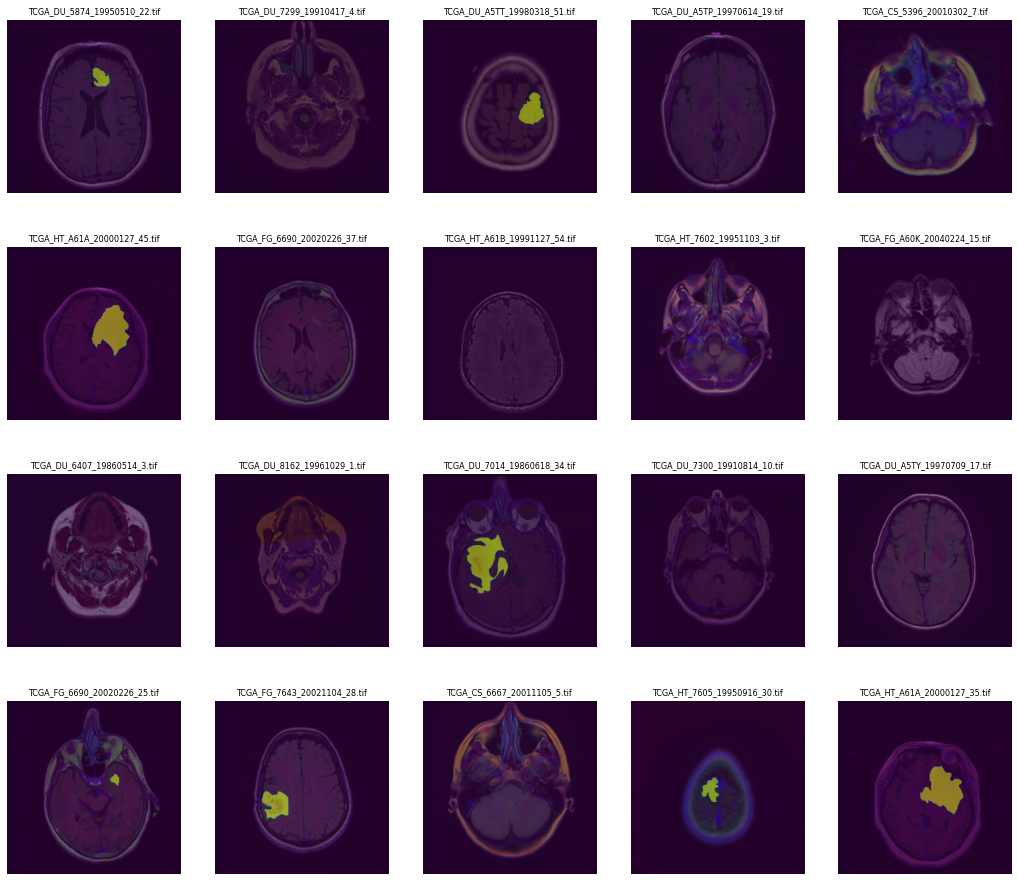

In [9]:
plot_random_masked_images(df, 20)

### Hwo does an image look without a proper mask?

In [10]:
def plot_one_image_mask(df: pd.DataFrame, img_name: str, path_masks: str = './kaggle_3m/masks/', 
                        path_images: str = './kaggle_3m/images/'):
    
    img_mask = df.loc[df['image'] == img_name, 'mask'].values[0]
    fig, ax = plt.subplots(figsize=(10, 4))
    plt.subplot(1,3,1)
    plt.imshow(PIL.Image.open(os.path.join(path_images, img_name)))
    plt.title('Image')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(PIL.Image.open(os.path.join(path_masks, img_mask)))
    plt.title('Mask')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(PIL.Image.open(os.path.join(path_images, img_name)))
    plt.imshow(PIL.Image.open(os.path.join(path_masks, img_mask)), alpha=.3)
    plt.title('Image + Mask')
    plt.axis('off')
    
    plt.show()

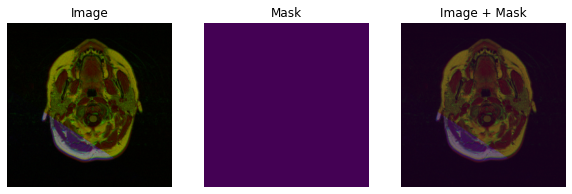

In [11]:
plot_one_image_mask(df, 'TCGA_FG_7643_20021104_3.tif')

In [12]:
PREPARE_DF = False

if PREPARE_DF:
    def make_mask_label(img_path):
        img_path = os.path.join('./kaggle_3m/masks/', img_path)
        img = np.asarray(PIL.Image.open(img_path))
        return True if img.sum() > 0 else False 
    
    df['has_segment_mask'] = df['mask'].apply(make_mask_label)
    
    if SAVE_DF:
        df.to_csv('./kaggle_3m/image_data.csv', index=False)
        
else:
    df = pd.read_csv('./kaggle_3m/image_data.csv')

In [13]:
df.head(2)

,identifier,image,mask,patient_key,has_segment_mask
0,TCGA_CS_4941_19960909_1,TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909_1_mask.tif,TCGA_CS_4941,False
1,TCGA_CS_4941_19960909_10,TCGA_CS_4941_19960909_10.tif,TCGA_CS_4941_19960909_10_mask.tif,TCGA_CS_4941,False


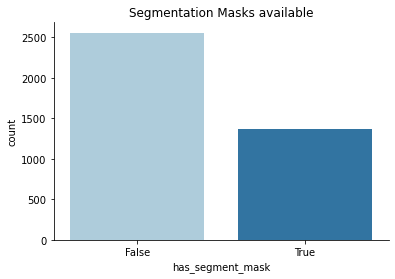

In [14]:
p = sns.countplot(x=df['has_segment_mask'], palette='Paired')
p.set_title('Segmentation Masks available')
sns.despine()
plt.show()

**Beschreibung:**

In [42]:
df.head(2)

,identifier,image,mask,patient_key,has_segment_mask
0,TCGA_CS_4941_19960909_1,TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909_1_mask.tif,TCGA_CS_4941,False
1,TCGA_CS_4941_19960909_10,TCGA_CS_4941_19960909_10.tif,TCGA_CS_4941_19960909_10_mask.tif,TCGA_CS_4941,False


In [44]:
BUILD_SET = False

if BUILD_SET:
    train, test = train_test_split(df, test_size=.1, random_state=10, stratify=df['has_segment_mask'])
    val, test = train_test_split(test, test_size=.5, random_state=10, stratify=test['has_segment_mask'])
    train['set'] = 'train'
    val['set'] = 'val'
    test['set'] = 'test'
    df = pd.concat([train, val, test], axis=0)
    df.to_csv('./kaggle_3m/image_data.csv', index=False)

In [15]:
# image dim
PIL.Image.open(os.path.join(new_path_images, 
                            df.loc[0, 'image'])).size

(256, 256)

## Build Model, Implementation of U-Net

In [16]:
summary(DoubleConvLayer(1, 64), input_size=(1, 572, 572), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 572, 572]             640
       BatchNorm2d-2         [-1, 64, 572, 572]             128
              ReLU-3         [-1, 64, 572, 572]               0
            Conv2d-4         [-1, 64, 572, 572]          36,928
       BatchNorm2d-5         [-1, 64, 572, 572]             128
              ReLU-6         [-1, 64, 572, 572]               0
Total params: 37,824
Trainable params: 37,824
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.25
Forward/backward pass size (MB): 958.55
Params size (MB): 0.14
Estimated Total Size (MB): 959.94
----------------------------------------------------------------


In [17]:
summary(UNet(in_channels=1, out_channels=1), input_size=(1, 256, 256), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             640
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
   DoubleConvLayer-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,856
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,584
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

In [19]:
image, mask = df.loc[0, ['image', 'mask']].values

In [20]:
image, mask

('TCGA_CS_4941_19960909_1.tif', 'TCGA_CS_4941_19960909_1_mask.tif')

## Setup Dataloader

In [32]:
image_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=(1., 1., 1.), std=(.5, .5, .5))
])

inverse_image_transforms = transforms.Compose([
    transforms.Normalize(mean=(0, 0, 0), std=(1/.5, 1/.5, 1/.5)),
    transforms.Normalize(mean=(-1, -1, -1), std=(1, 1, 1))
])

In [33]:
dataloader = get_dataloader(image_dir='./kaggle_3m/images/', 
                            mask_dir='./kaggle_3m/masks/', 
                            df=pd.read_csv('./kaggle_3m/image_data.csv'), 
                            transformations=image_transforms,
                            batch_size=1, workers=1,)

In [34]:
img, seg = next(iter(dataloader))

In [38]:
img.shape, seg.shape

(torch.Size([1, 1, 256, 256]), torch.Size([1, 1, 256, 256]))

## Model Training

In [39]:
class TrainingInterface():
    
    def __init__(self, model, name, writer: object = None):
        """
        Training Interface Wrapper class for the training of neural network classifier
        in pytorch. Only applicable for image classification.
        
        Params:
        -------------------
        model: (torch.model)     Neural Network class Pytorch     
        name: (str)              Name of Neural Network
        writer: (object)         If true uses wandb to log all outputs during training and inference
        
        dev:                     Device Cuda or cpu
        train_losses:            Training losses recorded during training
        eval_losses:             Validation Losses recorded during training
        """
        self.model = model
        self.name = name 
        self.writer = writer
        
        self.dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.epoch = 0
        self.batch_train_loss = []
        self.batch_val_loss = []
        self.epoch_train_loss = []
        self.epch_val_loss = []
        

    def print_network(self):
        """
        Prints networks and its layers.
        """
        print(self.model)
    
    def print_total_params(self, return_=False):
        """
        Prints total params.
        
        Params:
        -------------      
        return_:            if return the the result will be returned        
        """
        pytorch_total_params = sum(p.numel() for p in self.model.parameters())
                                  
        if not return_:
            print(50 * '=')
            print(f'{self.name} | Trainable Parameters: {pytorch_total_params}')
            print(50 * '=')
        else:
            return '{}\n{}\n{}'.format(50 * '=', pytorch_total_params, 50 * '=')
        
    def train(self, criterion, optimizer, n_epochs, dataloader_train, 
              dataloader_val=None, epsilon=.0001, verbose=True):
        self.model.to(self.dev)
        criterion.to(self.dev)

        self.model.train()
        overall_length = len(dataloader_train)
        with tqdm(total=n_epochs*overall_length) as pbar:
            for epoch in range(n_epochs):  # loop over the dataset multiple times
                running_loss, val_loss = 0., 0.
                for i, data in enumerate(dataloader_train):
                    # get the inputs; data is a list of [inputs, labels]
                    images, true_mask = data
                    images, true_mask = images.to(self.dev), true_mask.to(self.dev)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward + backward + optimize
                    out = self.model(images)
                    loss = criterion(out, true_mask)
                    loss.backward()
                    optimizer.step()

                    # calc and print stats
                    self.batch_train_loss.append(loss.item())
                    if self.writer != None:
                        self.writer.log({'train_batch_loss': loss.item()})
                        
                    running_loss += loss.item()                
                    pbar.set_description('Epoch: {}/{} // Running Loss: {} '.format(epoch+1, n_epochs, 
                                                                                    np.round(running_loss, 3)))   
                    pbar.update(1)
                
                self.epoch_train_loss.append(running_loss)
                if self.writer != None:
                    self.writer.log({'train_epoch_loss': running_loss})

                if dataloader_val:
                    length_dataloader_val = len(dataloader_val)
                    val_loss = 0.
                    for i, data in enumerate(dataloader_val):
                        pbar.set_description(f'Epoch: {epoch+1}/{n_epochs} // Eval-Loop: {i+1}/{length_dataloader_val}')
                        self.model.eval()
                        # get the inputs; data is a list of [inputs, labels]
                        inputs, labels = data
                        inputs, labels = inputs.to(self.dev), labels.to(self.dev)
                        with torch.no_grad():
                            outputs = self.model(inputs)
                            eval_loss = criterion(outputs, labels)
                            val_loss += eval_loss.item()
                            self.batch_val_loss.append(eval_loss.item())
                            if self.writer != None:
                                self.writer.log({'val_batch_loss': eval_loss.item()})
                        self.model.train()  
                    self.epoch_val_loss.append(val_loss)
                    
                    if self.writer != None:
                        self.writer.log({'val_epoch_loss': val_loss})
                
                # Update epoch
                self.epoch += 1
                
                if verbose:
                    print('Epoch {}/{}: [Train-Loss = {}] || [Validation-Loss = {}]'.format(self.epoch, n_epochs, 
                                                                                         np.round(running_loss, 3),     
                                                                                         np.round(val_loss, 3)))     
                if epoch > 0:
                    if epsilon > np.abs(loss_before - running_loss):
                        print(20*'=', 'Network Converged', 20*'=')
                        break
                loss_before = running_loss
                    
        return self
    
    def segment(self, dataloader, return_images: bool = True, return_prob: bool = True, 
                disable_pbar: bool = False):
        """
        Returns true and predicted labels for prediction
        Params:
        ---------
        model:           Pytorch Neuronal Net
        dataloader:      batched Testset
        return_images:   If true returns images
        return_prob:     If true returns predicted probabilities
        disable_pbar:    If true disables pbar
        returns:
        ----------
        (y_true, y_pred, y_images, y_prob): 
            y_true       True labels
            y_pred:      Predicted Labels
            y_prob:      Predicted Probability (empty if return_prob = False)
            y_images:    Images (empty if return_images = False)
        """
        self.model.to(self.dev)
        self.model.eval()
        y_pred, y_true, y_images, y_prob = [], [], [], [] 
        
        with torch.no_grad():
            for batch in tqdm(dataloader, desc='Calculate Predictions', disable=disable_pbar):
                images, labels = batch
                images, labels = images.to(self.dev), labels.to(self.dev)
                y_probs = F.sigmoid(self.model(images))
                
                #y_probs = F.softmax(self.model(images), dim = -1)
                
                if return_images:
                    y_images.append(images.cpu())
                y_prob.append(y_probs.cpu()) 
                y_true.append(labels.cpu())
                
        if return_images:
            y_images = torch.cat(y_images, dim = 0)
        
        y_prob = torch.cat(y_prob, dim = 0)
        y_true = torch.cat(y_true, dim = 0)
        y_pred = torch.argmax(y_prob, 1)        

        return (y_true, 
                y_pred, 
                y_images if return_images else None,
                y_prob if return_prob else None)

In [40]:
df

,identifier,image,mask,patient_key,has_segment_mask
0,TCGA_CS_4941_19960909_1,TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909_1_mask.tif,TCGA_CS_4941,False
1,TCGA_CS_4941_19960909_10,TCGA_CS_4941_19960909_10.tif,TCGA_CS_4941_19960909_10_mask.tif,TCGA_CS_4941,False
2,TCGA_CS_4941_19960909_11,TCGA_CS_4941_19960909_11.tif,TCGA_CS_4941_19960909_11_mask.tif,TCGA_CS_4941,True
3,TCGA_CS_4941_19960909_12,TCGA_CS_4941_19960909_12.tif,TCGA_CS_4941_19960909_12_mask.tif,TCGA_CS_4941,True
4,TCGA_CS_4941_19960909_13,TCGA_CS_4941_19960909_13.tif,TCGA_CS_4941_19960909_13_mask.tif,TCGA_CS_4941,True
...,...,...,...,...,...
3924,TCGA_HT_A61B_19991127_85,TCGA_HT_A61B_19991127_85.tif,TCGA_HT_A61B_19991127_85_mask.tif,TCGA_HT_A61B,False
3925,TCGA_HT_A61B_19991127_86,TCGA_HT_A61B_19991127_86.tif,TCGA_HT_A61B_19991127_86_mask.tif,TCGA_HT_A61B,False
3926,TCGA_HT_A61B_19991127_87,TCGA_HT_A61B_19991127_87.tif,TCGA_HT_A61B_19991127_87_mask.tif,TCGA_HT_A61B,False
3927,TCGA_HT_A61B_19991127_88,TCGA_HT_A61B_19991127_88.tif,TCGA_HT_A61B_19991127_88_mask.tif,TCGA_HT_A61B,False


In [ ]:
UNet()